# Building an ARIMA model for time series forecasting of river flow data


In [1]:
# import data and view as plot
from arima_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.ndimage
import numpy as np

# import data - using data from the Brahamaputra River, Bangladesh
file_path = "DATA/2651100_Q_Day.Cmd.txt"
metadata, data = read_data(file_path)
station_info, parsed_data = process_data(metadata, data)
# take the last 5 years of data
parsed_data = parsed_data[-365*5:]

print("Station Information:")
print(station_info)
print("Data:")
print(parsed_data.head())


Station Information:
{'GRDC-No.': '2651100', 'River': 'BRAHMAPUTRA RIVER', 'Station': 'BAHADURABAD', 'Country': 'BD', 'Latitude (DD)': '25.18', 'Longitude (DD)': '89.67', 'Catchment area (km²)': None, 'Altitude (m ASL)': '19.0', 'Time series': '1985-04 - 1992-03', 'No. of years': '8', 'Last update': '2018-05-29'}
Data:
           Date   Value
730  1987-04-03  4620.0
731  1987-04-04  4690.0
732  1987-04-05  5020.0
733  1987-04-06  5490.0
734  1987-04-07  5880.0


<Figure size 1000x600 with 0 Axes>

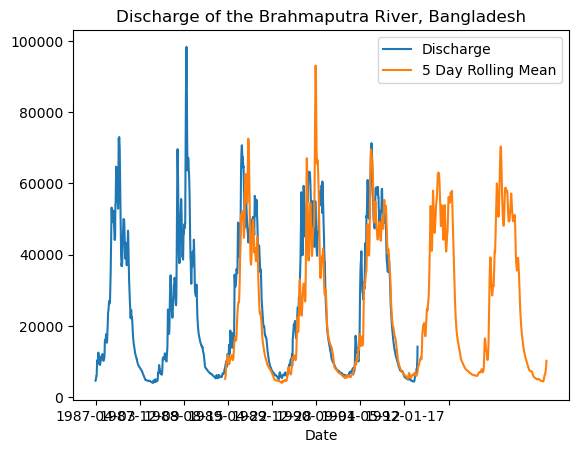

In [2]:
# plot the data
plt.figure(figsize=(10,6))
parsed_data.plot(y='Value', x='Date', title='Discharge of the Brahmaputra River, Bangladesh')
# add rolling mean value    
parsed_data['Value'].rolling(window=5).mean().plot()
parsed_data['Avg'] = parsed_data['Value'].rolling(window=5).mean()
plt.legend(['Discharge', '5 Day Rolling Mean'])
plt.show()

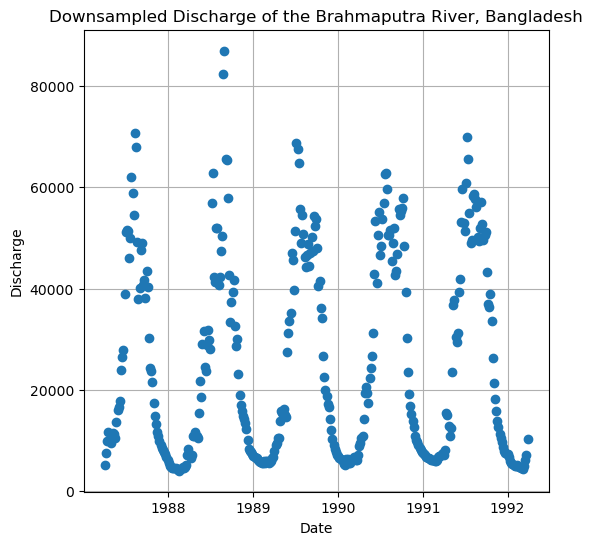

In [3]:
# downsample to 5 day intervals
parsed_data = downsample(parsed_data)

# Plot the downsampled data
plt.figure(figsize=(6, 6))
plt.plot(parsed_data['Sampled'], marker='o', linestyle='-')
plt.title('Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


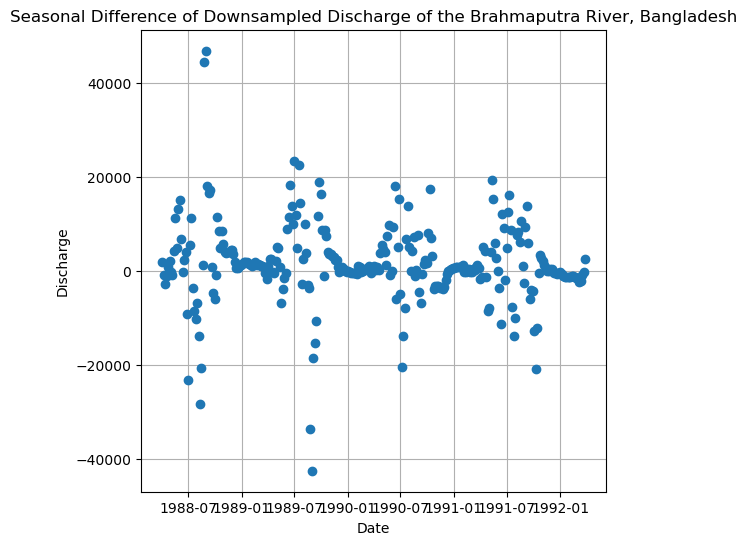

In [4]:
# as data will be seasonal, do seasonal differencing
parsed_data['Seasonal Difference'] = (parsed_data['Sampled'] - parsed_data['Sampled'].shift(365))
plt.figure(figsize=(6, 6))
plt.plot(parsed_data['Seasonal Difference'], marker='o', linestyle='-')
plt.title('Seasonal Difference of Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


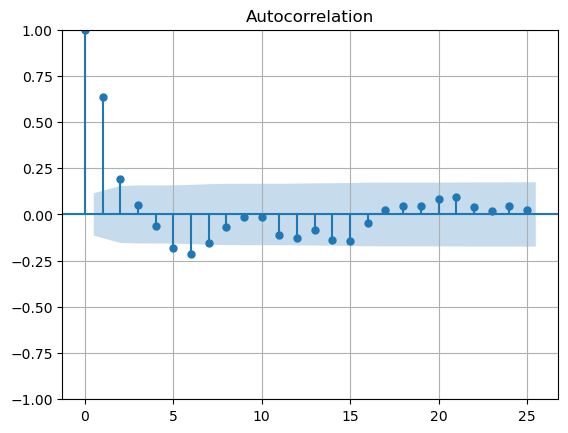

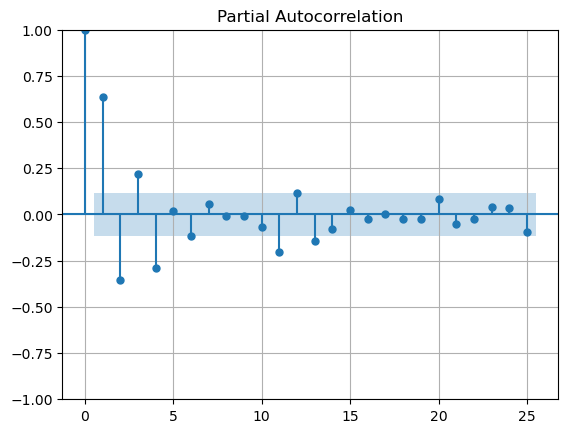

In [5]:
# calculate the ACF and PACF to determine order of ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(parsed_data['Seasonal Difference'].dropna())
# plt.hold(True)
grid = plt.grid(True)
plot_pacf(parsed_data['Seasonal Difference'].dropna())
grid = plt.grid(True)


Roughly reading from these plots:
- Predict around 1-2 auto-regressive terms
- 0 non-seasonal differences
- 2 lagged forecast errors

and for the seasonal component:
- 0 auto-regressive terms
- 1 seasonal difference
- 0 lagged forecast errors
with a seasonal period of 73 (365/5 due to down-sampling)

In [6]:
# split the data into training and testing sets
train, test = split_data(parsed_data, split=0.8)

# fit the ARIMA model
model = arima_model(train, order=(3,0,2), seasonal_order=(0,1,0,73))

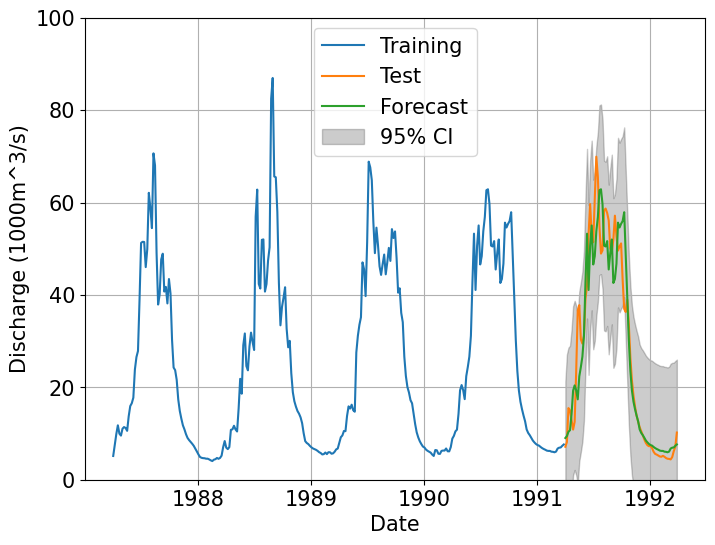

Mean Squared Error: 48944872.05579573
Root Mean Squared Error: 6996.06118153606
Mean Absolute Percentage Error: 18.69978049475219


In [20]:
# predict the future using the model and plot the results
forecast_data, forecast_ci = forecast(model, test)

# Create a date range for the forecast period
date_range = pd.date_range(start='2020-03-01', end='2025-03-01', freq='5D')

# print(forecast_data)
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='k', alpha=0.2, label='95% CI')
# plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Discharge (1000m^3/s)')
# change the y ticks so that its in thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x/1000)))
# change the x ticks so that the date is recent
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True)
plt.ylim(0, 100000)

plt.legend(loc='upper center')
plt.show()

# Compute the mean squared error
mse = mean_squared_error(test.dropna(), forecast_data.dropna())
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
mape = np.mean(np.abs((test.dropna() - forecast_data.dropna()) / test.dropna())) * 100
print("Mean Absolute Percentage Error:", mape)



In [8]:
# # find best model - switch to python to run this cell   
# import itertools

# # Define parameters for ARIMA orders
# p = range(0,5)  # AutoRegressive (AR) order
# d = [0]  # Integrated (I) order data is already stationary and downsampled
# q = range(0, 3)  # Moving Average (MA) order

# # Define seasonal parameters for ARIMA seasonal orders
# P = [0]  # Seasonal AutoRegressive (SAR) order
# D = range(0,2)  # Seasonal Integrated (SI) order 
# Q = [0]  # Seasonal Moving Average (SMA) order
# s = [73]  # Seasonal period 

# # Generate all possible combinations of parameters
# orders = list(itertools.product(p, d, q))
# seasonal_orders = list(itertools.product(P, D, Q, s))

# best_aic = float('inf')
# best_model = None

# # Iterate over all combinations of parameters and fit the models
# for order in orders:
#     for seasonal_order in seasonal_orders:
#         try:
#             model = ARIMA(train.dropna(), order=order, seasonal_order=seasonal_order)
#             model_fit = model.fit()

#             # Check if the current model has a lower AIC value than the best model found so far
#             if model_fit.aic < best_aic:
#                 best_aic = model_fit.aic
#                 best_model = model_fit
#                 best_order = order
#                 best_seasonal_order = seasonal_order

#         except:
#             continue

# # Print the summary of the best model
# print("Best Model:")
# print(best_model.summary())
# print("Best AIC:", best_aic)
# print("Best ARIMA Order:", best_order)
# print("Best Seasonal Order:", best_seasonal_order)

# # store the model
# # best_model.save('bramaputra_best_model.pkl')

In [9]:
# evaluate the model
# mse, rmse, mape = evaluate_model(model, test, plot=True)
# print("Mean Squared Error:", mse)
# print("Root Mean Squared Error:", rmse)
# print("Mean Absolute Percentage Error:", mape)



This model order generalises fairly well to the other river flow data sets, so it can be used for a range of river flow estimates - confirmed with 2 rivers in Bangladesh.

# Assess the model for world river flows

Using river data from more rivers to see the generalisability of the model.

Training the same model on each river, and then using the model to forecast the river flow for the next year. Evaluating the RMSE and MAPE of the forecasted river flow against the actual river flow.


In [10]:
rivers = {'Brahmaputra, BD': 'DATA/2651100_Q_Day.Cmd.txt',
            'Tista, BD': 'DATA/2651080_Q_Day.Cmd.txt', 
            'Tadi Khola, NP': 'DATA/2549220_Q_Day.Cmd.txt',
            'Chepe Khola, NP': 'DATA/2549230_Q_Day.Cmd.txt',
            'Ganges, BD': 'DATA/2646200_Q_Day.Cmd.txt',
            'Chindwin, MM': 'DATA/2260100_Q_Day.Cmd.txt',
            'Irrawaddy, MM': 'DATA/2260400_Q_Day.Cmd.txt',
            'Sittang, MM': 'DATA/2261500_Q_Day.Cmd.txt',
            'Canagua, VZ': 'DATA/3206080_Q_Day.Cmd.txt',
            'Guapore, BR': 'DATA/3617814_Q_Day.Cmd.txt',
            'Pacaas Novos, BR': 'DATA/3617130_Q_Day.Cmd.txt',
            # 'KYMIJOKI, FI': 'DATA/6854203_Q_Day.Cmd.txt',
            'Bermeho, AR': 'DATA/3268900_Q_Day.Cmd.txt',
            'Pampana, SL':'site_data/1216300_Q_Day.Cmd.txt',
            'Rokel, SL':'site_data/1216400_Q_Day.Cmd.txt',
            'Makana, SL':'site_data/1219500_Q_Day.Cmd.txt',
            'Lofa, LR':'site_data/1321880_Q_Day.Cmd.txt',
            'Saint Paul, LR':'site_data/1322880_Q_Day.Cmd.txt',
            'Cestos, LR':'site_data/1324580_Q_Day.Cmd.txt',
} # for finland use only last 10 years (and manual slope)



In [11]:
# results = {}

# for river, file_path in rivers.items():
#     metadata, data = read_data(file_path)
#     station_info, parsed_data = process_data(metadata, data)
#     parsed_data = downsample(parsed_data)
#     train, test = split_data(parsed_data, split=0.8)
#     model = arima_model(train, order=(3,0,2), seasonal_order=(0,1,0,73))
#     try:
#         mse, rmse, mape = evaluate_model(model, test, plot=False)
#     except ValueError:
#         mse, rmse, mape = None, None, None
#     results[river] = {'RMSE': rmse, 'MAPE': mape}

# print(results)


In [12]:
# plot only the MAPE
# mape = [results[river]['MAPE'] for river in results.keys()]
# plt.figure(figsize=(10,6))
# plt.bar(results.keys(), mape, color='skyblue')
# plt.title('Mean Absolute Percentage Error for Different Rivers')
# plt.xlabel('River')
# plt.ylabel('Mean Absolute Percentage Error')
# plt.show()

In [13]:
# print metadata
print(metadata)


{'Title': 'GRDC STATION DATA FILE', 'Format': 'DOS-ASCII', 'Field delimiter': ';', 'file generation date': '2024-02-29', 'GRDC-No.': '2651100', 'River': 'BRAHMAPUTRA RIVER', 'Station': 'BAHADURABAD', 'Country': 'BD', 'Latitude (DD)': '25.18', 'Longitude (DD)': '89.67', 'Catchment area (km²)': '636130.0', 'Altitude (m ASL)': '19.0', 'Next downstream station': '-', 'Remarks': '', 'Owner of original data': 'Initial dataset collected in the framework of the First GARP Global Experiment (FGGE)', 'Data Set Content': 'MEAN DAILY DISCHARGE (Q)', 'Unit of measure': 'm³/s', 'Time series': '1985-04 - 1992-03', 'No. of years': '8', 'Last update': '2018-05-29', 'Table Header': '', 'hh': 'mm      - Time', 'Data lines': '2555'}


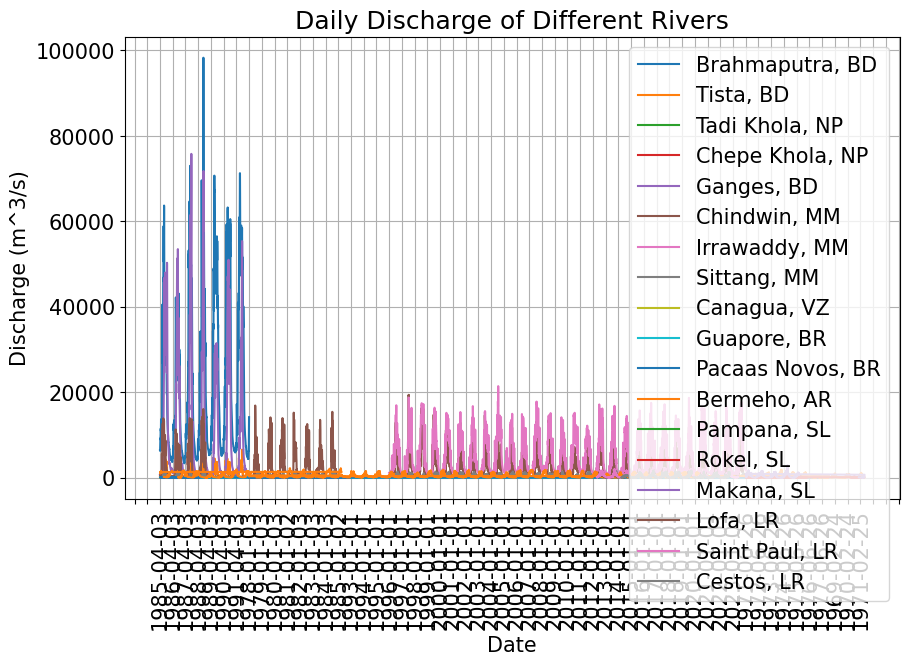

In [14]:
# plot the raw data for the rivers on one plot
plt.figure(figsize=(10,6))
for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    # parsed_data = downsample(parsed_data)
    # plot time series against date for each river
    plt.plot(parsed_data['Date'], parsed_data['Value'], label=river)
    
plt.title('Daily Discharge of Different Rivers')
plt.ylabel('Discharge (m^3/s)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

# Set xticks to only show once a year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

plt.show()

Using the lat and lon provided for each on the rivers, attempt to scale the discharge to get an estimate of velocity.


IndexError: list index out of range

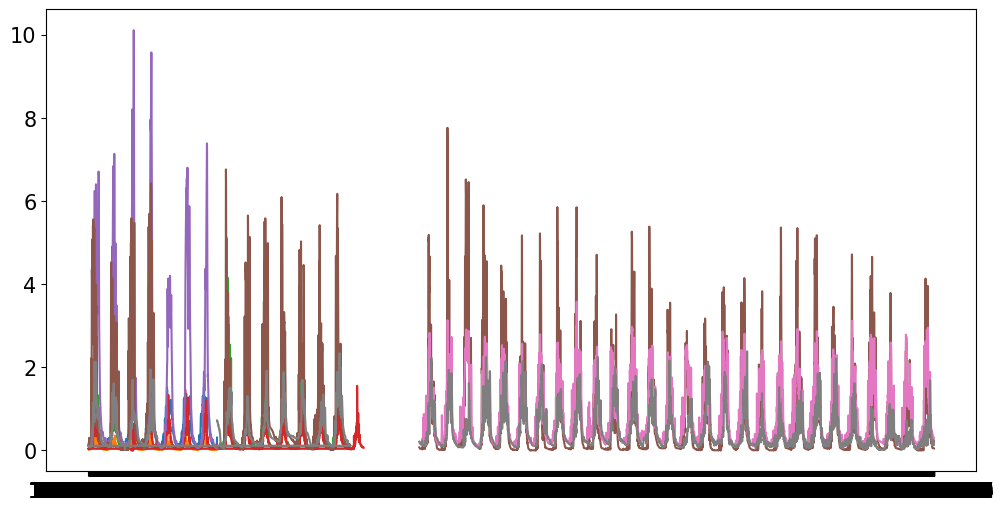

In [15]:
width_estimates = [9310, 2200, 50, 50, 1500, 500, 1200, 130] # in meters
depth_estimates = [5, 5, 2, 2, 5, 5, 5, 5] # in meters assuming 2,5,10 meters for small, medium, large rivers

plt.figure(figsize=(12,6))
i = 0
for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    # parsed_data = downsample(parsed_data)
    # plot time series against date for each river
    parsed_data['Width'] = width_estimates[i]
    parsed_data['Depth'] = depth_estimates[i]
    parsed_data['Velocity'] = parsed_data['Value'] / (parsed_data['Width'] * parsed_data['Depth'])

    plt.plot(parsed_data['Date'], parsed_data['Velocity'], label=river)
    i += 1

plt.title('Velocity of Different Rivers')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

# Set xticks to only show once a year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

plt.show()

With this rough estimate of velocity (using google maps to get the river width at each station coordinates) I can plot the estimated river velocity timeseries for each river.

Now I can attempt to fit the arrima model to the river velocity data, and see if the model generalises to river velocity data, and if it can predict the river velocity for the next year.

Estimated Depth: 4.966187620527828


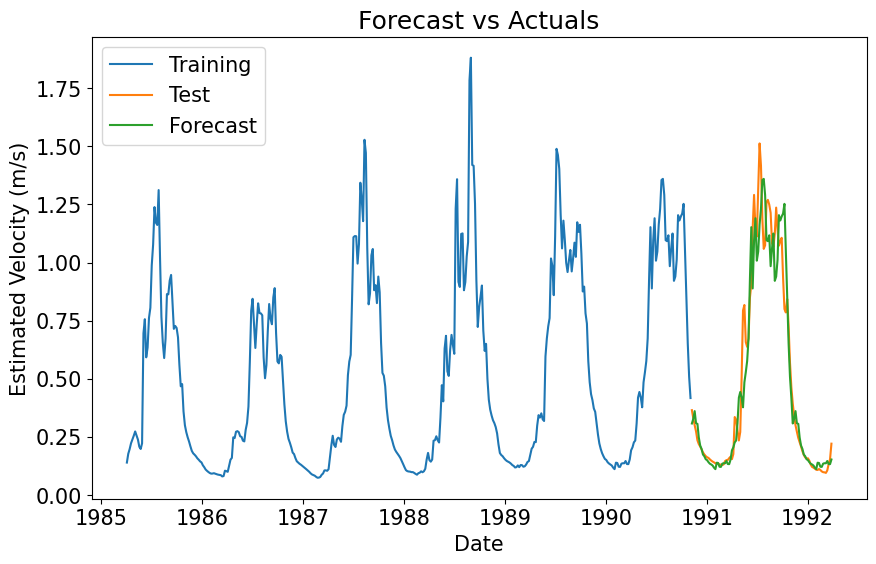

ValueError: too many values to unpack (expected 2)

In [ ]:
# using the velocity data for the Brahmaputra River, Bangladesh
metadata, data = read_data('DATA/2651100_Q_Day.Cmd.txt')
station_info, parsed_data = process_data(metadata, data)

# depth estimates using the paper
# Q = W^1.02 * D^1.74 * S^0.35
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = 9310 # width in meters
S = 2.82 / 1000 # average slope m/m 

D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters

width = 9310
depth = D

print("Estimated Depth:", D)

parsed_data['Velocity'] = parsed_data['Value'] / (width * depth)
parsed_data = downsample(parsed_data)

# split the data into training and testing sets
train, test = split_data(parsed_data, split=0.8)

# fit the ARIMA model
model = arima_model(train, order=(3,0,2), seasonal_order=(0,1,0,73))

# predict the future using the model and plot the results
forecast_data, forecast_ci = forecast(model, test)
# plot the confidence intervals
# forecast_data, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals')
plt.ylabel('Estimated Velocity (m/s)')
plt.xlabel('Date')
plt.legend()
plt.show()

# evaluate the model
mse, rmse, mape = evaluate_model(model, test, plot=False)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

Estimated Depth: 8.384024996765582


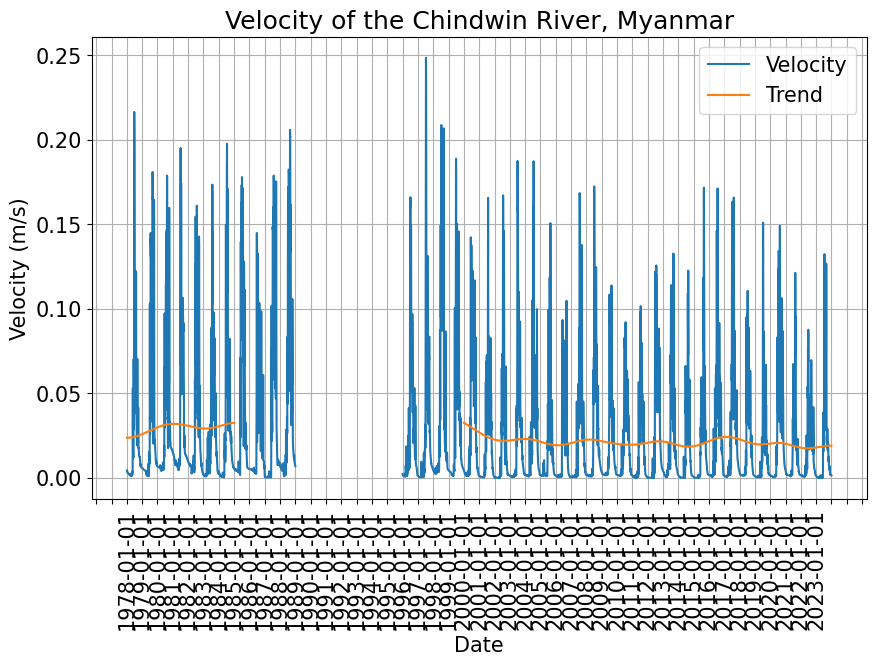

In [ ]:
# long term trends in the data
# looking at the Myanmar rivers as they have the longest data
metadata, data = read_data('DATA/2260100_Q_Day.Cmd.txt')
station_info, parsed_data = process_data(metadata, data)

# depth estimates using the paper
# Q = W^1.02 * D^1.74 * S^0.35
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = 500 # width in meters
S = 0.89 / 1000 # average slope m/m from Wikipedia

D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters

width = 9310
depth = D

print("Estimated Depth:", D)
depth = D
parsed_data['Velocity'] = parsed_data['Value'] / (width * depth)

# plot the data and an trend line
plt.figure(figsize=(10,6))
plt.plot(parsed_data['Date'], parsed_data['Velocity'], label='Velocity')

# use gaussian filter to smooth the data
plt.plot(parsed_data['Date'],scipy.ndimage.gaussian_filter1d(parsed_data['Velocity'], sigma=365) , label='Trend')

plt.title('Velocity of the Chindwin River, Myanmar')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

# Set xticks to only show once a year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

plt.show()

# Look at the trends of various rivers over time to see if there are any interesting patterns 

Do a normalised plot of trends for each river, the trend will look at year on year change to the flow.

Trend Slope: -0.06538414893877147
Average Absolute Percentage Change: 13.467247040981158


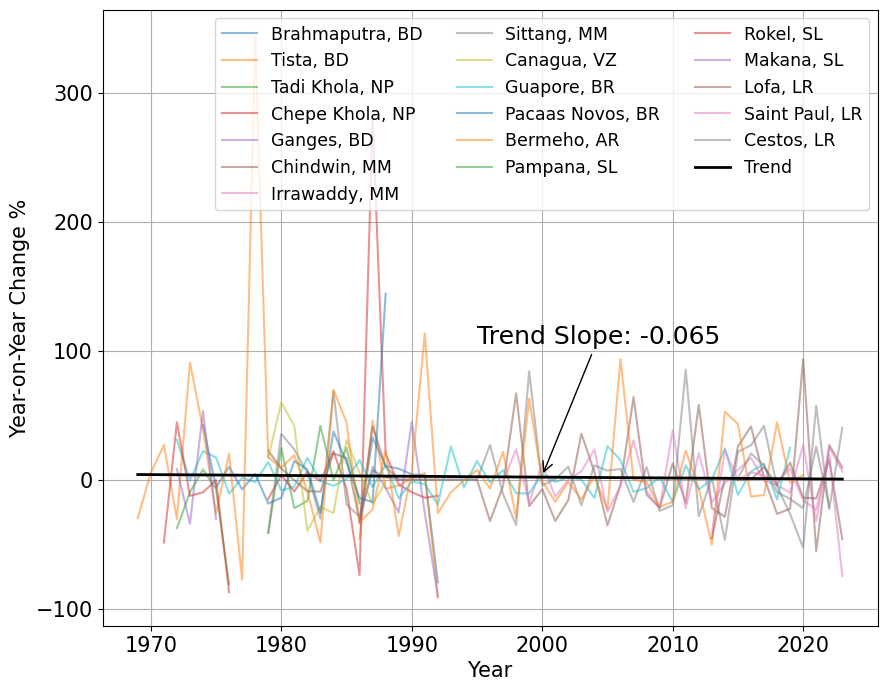

In [23]:
plt.figure(figsize=(10, 8))

total_df = pd.DataFrame()
# total_df.columns = rivers.keys()

for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    parsed_data['Year'] = pd.to_datetime(parsed_data['Date']).dt.year
    # resample the data to yearly
    parsed_data = parsed_data.groupby('Year')
    parsed_data = parsed_data.agg({'Value': 'mean'}).reset_index()
    parsed_data['Yearly Change'] = parsed_data['Value'].pct_change() * 100
    yearly_change = parsed_data.groupby('Year')['Yearly Change'].mean()
    plt.plot(yearly_change, label=river, alpha=0.5)

    # add to the total dataframe with corresponding years
    total_df = pd.concat([total_df, yearly_change], axis=1)


# reorder the rows
total_df = total_df.sort_index()

# caluclate mean of all the rivers ignoring NaN values
total_df['mean'] = total_df.mean(axis=1).dropna()
# total_df = total_df.dropna()

# Drop rows with NaN value in 'mean'
total_df = total_df.dropna(subset=['mean'])
# do a straightline fit to the data drop rows with NaN value mean
x = total_df.index
y = total_df['mean']
m, c = np.polyfit(x, y, 1)
total_df['Trend'] = m*x + c
print("Trend Slope:", m)

# plot the trend line
plt.plot(total_df.index, total_df['Trend'], label='Trend', color='black', linewidth=2)

# annotate the trend slope with an arrow
# plt.annotate('Trend Slope: {:.2f}'.format(m), xy=(10,10), xytext=(0.5, 0.6))

# print the average absolute percentage change
print("Average Absolute Percentage Change:", abs(total_df['mean']).mean())

plt.annotate('Trend Slope: {:.3f}'.format(m), xy=(2000, 3), xytext=(1995, 105), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=18)

# print(total_df.head(20))
# plot the mean of all the rivers
# plt.plot(total_df.index, total_df['mean'], label='Mean', color='black', linewidth=2, linestyle='--')

# print(parsed_data.head()) 
# plt.title('Year-on-Year Change in Discharge')
plt.xlabel('Year')
plt.ylabel('Year-on-Year Change %')
plt.legend(fontsize='small', ncol=3)
plt.grid(True)
plt.show()


All are consistently showing a positive trend, with the exception of the Ganges river which is showing a negative trend in the early 90s. These data are consistent with literature that suggests that river discharge is increasing due to climate change.

# Look at the variability of the river flow

Do a normalised plot of the variability for each river, the variability will look at the standard deviation of the river flow for each year.

Trend Slope: 0.0019525815189694777


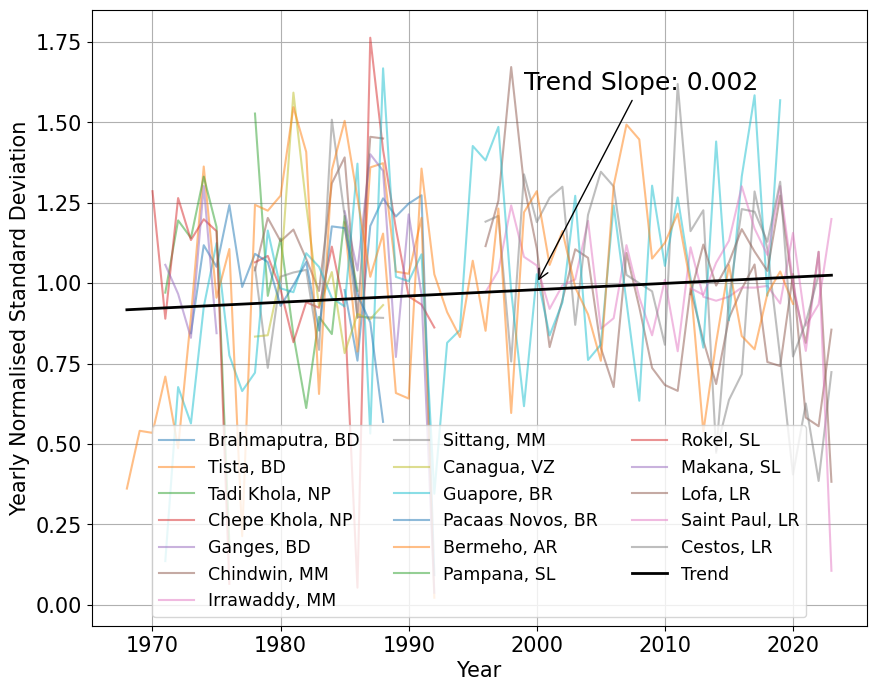

In [ ]:
plt.figure(figsize=(10, 8))

totalsd_df = pd.DataFrame()

# look at yearly normalised standard deviation for the rivers
for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    parsed_data['Year'] = pd.to_datetime(parsed_data['Date']).dt.year

    # resample the data to yearly
    parsed_data = parsed_data.groupby('Year')
    parsed_data = parsed_data.agg({'Value': 'std'}).reset_index()
    parsed_data['Yearly Standard Deviation'] = parsed_data['Value'] / parsed_data['Value'].mean()
    yearly_std = parsed_data.groupby('Year')['Yearly Standard Deviation'].mean()
    plt.plot(yearly_std, label=river, alpha=0.5)
    

    # add to the total dataframe with corresponding years
    totalsd_df = pd.concat([totalsd_df, yearly_std], axis=1)

# reorder the rows
totalsd_df = totalsd_df.sort_index()

# caluclate mean of all the rivers ignoring NaN values
totalsd_df['mean'] = totalsd_df.mean(axis=1).dropna()
# totalsd_df = totalsd_df.dropna()

# Drop rows with NaN value in 'mean'
totalsd_df = totalsd_df.dropna(subset=['mean'])
# do a straightline fit to the data drop rows with NaN value mean
x = totalsd_df.index
y = totalsd_df['mean']
m, c = np.polyfit(x, y, 1)
totalsd_df['Trend'] = m*x + c
print("Trend Slope:", m)

# plot the trend line
plt.plot(totalsd_df.index, totalsd_df['Trend'], label='Trend', color='black', linewidth=2)

# annotate the trend slope with an arrow
# plt.annotate('Trend Slope: {:.2f}'.format(m), xy=(10,10), xytext=(0.5, 0.6))

plt.annotate('Trend Slope: {:.3f}'.format(m), xy=(2000, 1), xytext=(1999, 1.6), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=18)

# plt.title('Yearly Normalised Standard Deviation in Discharge')
plt.xlabel('Year')
plt.ylabel('Yearly Normalised Standard Deviation')
# legend with 2 columns
plt.legend(fontsize='small', ncol=3)
plt.grid(True)
plt.show()

